# Importing Necessary Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

#For Logistic Regression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Preview of cleaned dataset

In [2]:
df = pd.read_csv("20k cleaned.csv")
df.set_index("id", inplace=True)
df.head()

,title,text,label,label_translated,title_char_count,text_char_count,title_word_count,text_word_count,title_stopword_count,text_stopword_count,text_lemmatized,title_lemmatized,title_polarity,title_polarity_score,text_polarity,text_polarity_score,title_emotion,text_emotion
id,,,,,,,,,,,,,,,,,,
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment expected Barack Obama Members FYF F...,0,fake,130,5049,18,871,6,48,No comment expect Barack Obama Members FYF Fuk...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,neutral,0.630,neutral,0.645,Surprise,Happy
1,UNBELIEVABLE! OBAMA S ATTORNEY GENERAL SAYS MO...,Now demonstrators gathered last night exercisi...,0,fake,145,216,18,34,0,46,Now demonstrator gather last night exercise co...,UNBELIEVABLE! OBAMA S ATTORNEY GENERAL SAYS MO...,positive,0.511,neutral,1.000,neutral,neutral
2,Bobby Jindal raised Hindu uses story Christian...,A dozen politically active pastors came privat...,1,real,105,8120,16,1321,0,16,A dozen politically active pastor come private...,Bobby Jindal raise Hindu use story Christian c...,neutral,1.000,neutral,0.526,neutral,neutral
3,SATAN Russia unvelis image terrifying new SUPE...,The RS Sarmat missile dubbed Satan replace SS ...,0,fake,101,1932,16,329,1,10,The RS Sarmat missile dub Satan replace SS Fli...,SATAN Russia unvelis image terrify new SUPERNU...,neutral,0.519,neutral,1.000,neutral,neutral
4,About Time! Christian Group Sues Amazon SPLC D...,All say one time someone sued Southern Poverty...,0,fake,78,1530,13,244,4,7,All say one time someone sue Southern Poverty ...,About Time! Christian Group Sues Amazon SPLC D...,neutral,1.000,neutral,1.000,Surprise,neutral


In [3]:
df.shape

(22012, 18)

In [4]:
df['label_translated'].value_counts()

fake    11212
real    10800
Name: label_translated, dtype: int64

# Testing for best indicator

In [5]:
def auto_kfold_decision_tree(variables):
    global newsdata_ohe
    # Init list to record scores
    scores = {}
    
    # Response
    news_res = df['label_translated']
    
    # Train for every variable
    for variable in variables:
        if variable.dtype == np.dtype('int64'):
            # Numeric variable
            news_cat = pd.DataFrame(variable)
            newsdata_ohe = pd.concat([news_cat, news_res], sort = False, axis = 1).reindex(index=news_cat.index)
        elif variable.dtype == np.dtype('object'):
            # Categorical variables
            # Import the encoder from sklearn
            ohe = OneHotEncoder()
            # OneHotEncoding of categorical predictors (not the response)
            news_cat = pd.DataFrame(variable)

            ohe.fit(news_cat)
            news_cat_ohe = pd.DataFrame(ohe.transform(news_cat).toarray(), columns=ohe.get_feature_names_out(news_cat.columns))
            
            newsdata_ohe = pd.concat([news_cat_ohe, news_res], sort = False, axis = 1).reindex(index=news_cat_ohe.index)

        # Extract Response and Predictors
        y = pd.DataFrame(newsdata_ohe['label_translated'])
        X = pd.DataFrame(newsdata_ohe.drop('label_translated', axis = 1))

        # Split the Dataset into Train and Test
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

        # Decision Tree using Train Data
        dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
        cv_results = cross_val_score(dectree, x_train, y_train['label_translated'], cv=skf)

        # Record score
        scores[variable.name] = cv_results
        
    return scores

In [6]:
variables = [
             df['title_word_count'], 
             df['text_word_count'], 
             df['title_stopword_count'], 
             df['text_stopword_count'], 
             df['title_polarity'], 
             df['text_polarity'], 
             df['title_emotion'], 
             df['text_emotion']
            ]

scores = auto_kfold_decision_tree(variables)


for key, value in sorted(scores.items(), key=lambda x: x[1].mean(), reverse=True):
    print(f"Predictor: {key}, score: {value.mean():.2f}")

Predictor: title_word_count, score: 0.65
Predictor: text_emotion, score: 0.61
Predictor: text_word_count, score: 0.61
Predictor: title_emotion, score: 0.54
Predictor: text_polarity, score: 0.52
Predictor: title_polarity, score: 0.52
Predictor: text_stopword_count, score: 0.51
Predictor: title_stopword_count, score: 0.51


# Top 3 Best Indicators: 
1) Title wordcount<br>
2) Text Emotion<br>
3) Text wordcount

### Encoding text_emotion into int from string

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['text_emotion'] = le.fit_transform(np.ravel(df[['text_emotion']]))
df.head()

,title,text,label,label_translated,title_char_count,text_char_count,title_word_count,text_word_count,title_stopword_count,text_stopword_count,text_lemmatized,title_lemmatized,title_polarity,title_polarity_score,text_polarity,text_polarity_score,title_emotion,text_emotion
id,,,,,,,,,,,,,,,,,,
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment expected Barack Obama Members FYF F...,0,fake,130,5049,18,871,6,48,No comment expect Barack Obama Members FYF Fuk...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,neutral,0.630,neutral,0.645,Surprise,2
1,UNBELIEVABLE! OBAMA S ATTORNEY GENERAL SAYS MO...,Now demonstrators gathered last night exercisi...,0,fake,145,216,18,34,0,46,Now demonstrator gather last night exercise co...,UNBELIEVABLE! OBAMA S ATTORNEY GENERAL SAYS MO...,positive,0.511,neutral,1.000,neutral,5
2,Bobby Jindal raised Hindu uses story Christian...,A dozen politically active pastors came privat...,1,real,105,8120,16,1321,0,16,A dozen politically active pastor come private...,Bobby Jindal raise Hindu use story Christian c...,neutral,1.000,neutral,0.526,neutral,5
3,SATAN Russia unvelis image terrifying new SUPE...,The RS Sarmat missile dubbed Satan replace SS ...,0,fake,101,1932,16,329,1,10,The RS Sarmat missile dub Satan replace SS Fli...,SATAN Russia unvelis image terrify new SUPERNU...,neutral,0.519,neutral,1.000,neutral,5
4,About Time! Christian Group Sues Amazon SPLC D...,All say one time someone sued Southern Poverty...,0,fake,78,1530,13,244,4,7,All say one time someone sue Southern Poverty ...,About Time! Christian Group Sues Amazon SPLC D...,neutral,1.000,neutral,1.000,Surprise,5


In [8]:
news_num = df[['title_word_count','text_emotion','text_word_count']]
news_res = df['label_translated']
news_final = pd.concat([news_num,news_res],sort=False,axis=1).reindex(index=news_num.index)
# Check the final dataframe
news_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22012 entries, 0 to 22011
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title_word_count  22012 non-null  int64 
 1   text_emotion      22012 non-null  int32 
 2   text_word_count   22012 non-null  int64 
 3   label_translated  22012 non-null  object
dtypes: int32(1), int64(2), object(1)
memory usage: 773.9+ KB


# Model Training: Logistic Regression, Decision Tree, Random Forest, Support Vector Machine Classifier, Ensemble

## Model 1 : Logistic Regression Model (Title only)

### Step 1 : TF-IDF Analysis

In [9]:
tfidf = TfidfVectorizer(stop_words='english',
                        strip_accents=None,
                        lowercase=True,
                        preprocessor=None,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=False, max_features=15000)

In [10]:
def tfidf_top_n_features(tfidf_data, features, n): 
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns = features)
    tfidf_df = tfidf_df.transpose()
    tfidf_means = np.mean(tfidf_df, axis=1)
    tfidf_df_summed = pd.DataFrame({'feature':tfidf_means.index, 'avg_tfidf':tfidf_means.values})
    tfidf_df_summed = tfidf_df_summed.sort_values(by='avg_tfidf', ascending=False)[:n]
    return tfidf_df_summed

### Extract top 15 features of title and content from Real and Fake News

### Top 15 features of title

In [11]:
tfidf_title_data = tfidf.fit_transform(df['title'])
tfidf_title_features = tfidf.get_feature_names_out()
tfidf_top_n_features(tfidf_title_data, tfidf_title_features, 15)

,feature,avg_tfidf
13492,trump,0.033033
8225,new,0.020477
14178,video,0.017489
14916,york,0.016650
13134,times,0.016525
10787,says,0.011719
6237,hillary,0.011178
2105,clinton,0.011041
8345,obama,0.010767
6350,house,0.007964


### Top 15 features of title and text from Fake News

In [12]:
tfidf_title_fake_data = tfidf.fit_transform(df.loc[df['label'] == 1]['title'])
tfidf_title_fake_features = tfidf.get_feature_names_out()
tfidf_top_n_features(tfidf_title_fake_data, tfidf_title_fake_features, 15)

,feature,avg_tfidf
11057,trump,0.032189
7092,new,0.029198
11943,york,0.026064
10826,times,0.025680
9312,says,0.017465
1314,breitbart,0.011887
5073,house,0.011333
1967,clinton,0.009056
7236,obama,0.008647
9203,russia,0.008215


In [13]:
tfidf_title_fake_data = tfidf.fit_transform(df.loc[df['label'] == 1]['text'])
tfidf_title_fake_features = tfidf.get_feature_names_out()
tfidf_top_n_features(tfidf_title_fake_data, tfidf_title_fake_features, 15)

,feature,avg_tfidf
11734,said,0.053082
13923,trump,0.049501
8761,mr,0.027864
10272,president,0.023288
12815,state,0.018563
2440,clinton,0.018439
11393,reuters,0.017887
6455,house,0.017787
9725,people,0.017124
8966,new,0.017067


### Top 15 features of title and text from Real News

In [14]:
tfidf_title_real_data = tfidf.fit_transform(df.loc[df['label'] == 0]['title'])
tfidf_title_real_features = tfidf.get_feature_names_out()
tfidf_top_n_features(tfidf_title_real_data, tfidf_title_real_features, 15)

,feature,avg_tfidf
12692,trump,0.034551
13174,video,0.027244
5709,hillary,0.017109
2209,clinton,0.012974
8364,obama,0.012848
13379,watch,0.010475
6608,just,0.009307
3651,donald,0.008453
8192,new,0.007956
9378,president,0.007880


In [15]:
tfidf_title_real_data = tfidf.fit_transform(df.loc[df['label'] == 0]['text'])
tfidf_title_real_features = tfidf.get_feature_names_out()
tfidf_top_n_features(tfidf_title_real_data, tfidf_title_real_features, 15)

,feature,avg_tfidf
13872,trump,0.057427
2365,clinton,0.027227
11689,said,0.022472
6266,hillary,0.021248
10297,president,0.020814
9758,people,0.020444
9144,obama,0.017993
4050,donald,0.015987
7819,like,0.014795
8966,new,0.013642


### Step 2 : Model Training

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df['title'], df['label_translated'], test_size=0.2)

In [17]:
print(f"Train: {x_train.shape[0]} & {y_train.shape[0]}")
print(f"Test: {x_test.shape[0]} & {y_test.shape[0]}")

Train: 17609 & 17609
Test: 4403 & 4403


### Implementing a models accuracy table

In [18]:
accuracy_df = pd.DataFrame(columns = ['Model', 'Accuracy', ' True Pos', 'False Pos', 'True Neg', 'False Neg'])
def update_accuracy(cm, acc, model):
    df = [1,2,3,4,5,6]
    FP = float(cm[0][1])
    TP = float(cm[1][1])
    FN = float(cm[1][0])
    TN = float(cm[0][0])
    TPR = (TP/(TP+FP))*100
    FPR = 100 - TPR
    TNR = (TN/(TN+FN))*100
    FNR = 100 - TNR
    df[0] = model
    df[1] = round(float(acc*100),1)
    df[2] = round(float(TPR),1)
    df[3] = round(float(FPR),1)
    df[4] = round(float(TNR),1)
    df[5] = round(float(FNR),1)
    return df    

### Step 3 : K-Fold Cross Validation to estimate performance of model

In [19]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

# Send all docs to fit
tfidf_train = tfidf.fit_transform(x_train)
tfidf_test = tfidf.transform(x_test)

In [20]:
logreg = LogisticRegression(penalty='l2', C=1.0)

In [21]:
# Init Stratified K fold cross validation object
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Run k-fold using logistic regression
cv_results = cross_val_score(logreg, tfidf_train, y_train, cv=sf)

In [22]:
# Print performance of each training and the average training score
for score in cv_results:
    print(f"Score: {score :.5f}")

print(f"Mean score: {cv_results.mean() :.5f}")

Score: 0.92959
Score: 0.92447
Score: 0.92646
Score: 0.92135
Score: 0.92928
Mean score: 0.92623


No sign of *overfitting* or *underfitting*. Great result!

### Printing the confusion matrix and accuracy

In [23]:
logreg.fit(tfidf_train, y_train)


y_train_pred = logreg.predict(tfidf_train)
print("Train Data")
print("Accuracy  :\t", logreg.score(tfidf_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

Train Data
Accuracy  :	 0.9599068658072577

TPR Train :	 0.9590819520111279
TNR Train :	 0.9606991761300379

FPR Train :	 0.03930082386996215
FNR Train :	 0.04091804798887214


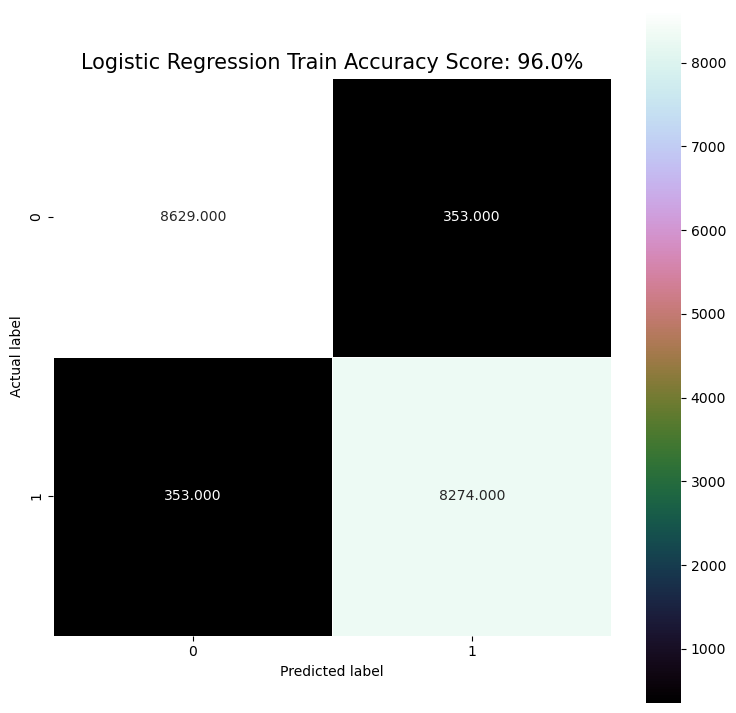

In [24]:
log_pred = logreg.predict(tfidf_train.toarray())
log_accuracy = accuracy_score(y_train,log_pred)
log_cm = metrics.confusion_matrix(y_train, log_pred)

plt.figure(figsize=(9,9))
sns.heatmap(log_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Logistic Regression Train Accuracy Score: {0:.1f}%'.format(log_accuracy*100)
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(log_cm, log_accuracy, "Logistic-Regression Train")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

In [25]:
y_test_pred = logreg.predict(tfidf_test)
print("Test Data")
print("Accuracy  :\t", logreg.score(tfidf_test, y_test))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

Test Data
Accuracy  :	 0.9320917556211674
TPR Test :	 0.9346525540727105
TNR Test :	 0.9295964125560539

FPR Test :	 0.07040358744394619
FNR Test :	 0.06534744592728946


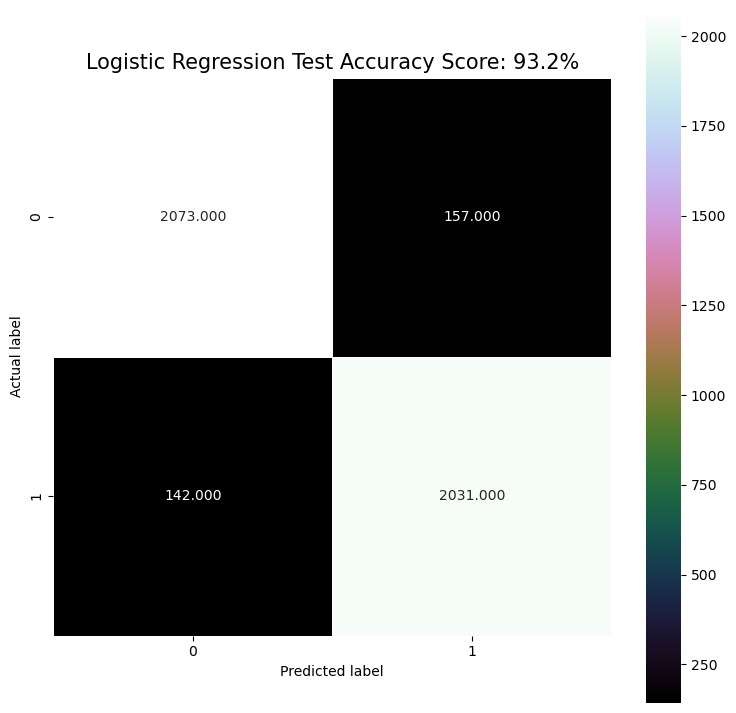

In [26]:
log_pred = logreg.predict(tfidf_test.toarray())
log_accuracy = accuracy_score(y_test,log_pred)
log_cm = metrics.confusion_matrix(y_test, log_pred)

plt.figure(figsize=(9,9))
sns.heatmap(log_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Logistic Regression Test Accuracy Score: {0:.1f}%'.format(log_accuracy*100)
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(log_cm, log_accuracy, "Logistic-Regression Test")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

Logistic Regression performed quite well of **96.1%** for training accuracy and **92.9%** for testing accuracy. The **gap difference of accuracy is quite minimal** which makes this a good model.

## Model 2 : Decision Tree

In [27]:
y = pd.DataFrame(news_final['label_translated']) #Response
x = pd.DataFrame(news_final.drop('label_translated', axis = 1)) #Predictors

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

print(f"Train: {x_train.shape[0]} & {y_train.shape[0]}")
print(f"Test: {x_test.shape[0]} & {y_test.shape[0]}")



Train: 17609 & 17609
Test: 4403 & 4403


In [28]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 4)
clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
print("Train Data")
print("Accuracy  :\t", clf.score(x_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))



Train Data
Accuracy  :	 0.7183258560963144

TPR Train :	 0.7625
TNR Train :	 0.6749915626054674

FPR Train :	 0.32500843739453256
FNR Train :	 0.2375


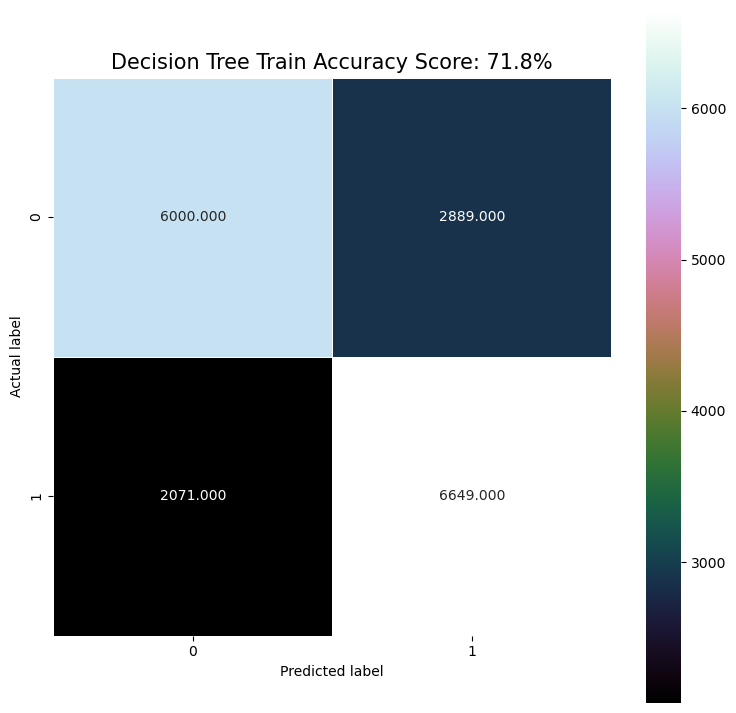

In [29]:
tree_pred = clf.predict(x_train)
tree_accuracy = accuracy_score(y_train,tree_pred)
tree_cm = metrics.confusion_matrix(y_train, tree_pred)

plt.figure(figsize=(9,9))
sns.heatmap(tree_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Decision Tree Train Accuracy Score: {0:.1f}%'.format(tree_accuracy*100)
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(tree_cm, tree_accuracy, "Decision Tree Train")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

In [30]:
y_test_pred = clf.predict(x_test)
print("Test Data")
print("Accuracy  :\t", clf.score(x_test, y_test))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

Test Data
Accuracy  :	 0.7111060640472405
TPR Test :	 0.7504807692307692
TNR Test :	 0.6758501937150236

FPR Test :	 0.3241498062849763
FNR Test :	 0.24951923076923077


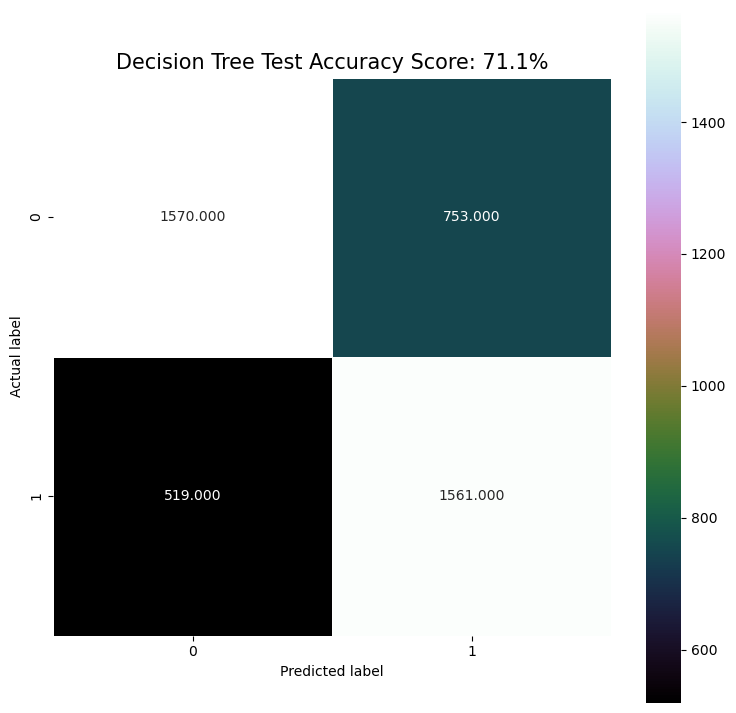

In [31]:
tree_pred = clf.predict(x_test)
tree_accuracy = accuracy_score(y_test,tree_pred)
tree_cm = metrics.confusion_matrix(y_test, tree_pred)

plt.figure(figsize=(9,9))
sns.heatmap(tree_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Decision Tree Test Accuracy Score: {0:.1f}%'.format(tree_accuracy*100)
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(tree_cm, tree_accuracy, "Decision Tree Test")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

Decision Tree has a **slightly lower accuracy** of both training and testing of around **71%**. The gap difference however is **less than 1%**, which is **ideal** when testing the model.

## Model 3 : Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators = 100,  #Number of trees
                                 max_depth = 4)       #Max number of levels in the tree

In [33]:
rforest.fit(x_train, y_train.label_translated.ravel())

RandomForestClassifier(max_depth=4)

In [34]:
y_train_pred = rforest.predict(x_train)
print("Train Data")
print("Accuracy  :\t", rforest.score(x_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

Train Data
Accuracy  :	 0.7306490998921006

TPR Train :	 0.7654816513761468
TNR Train :	 0.6964787940150748

FPR Train :	 0.3035212059849252
FNR Train :	 0.2345183486238532


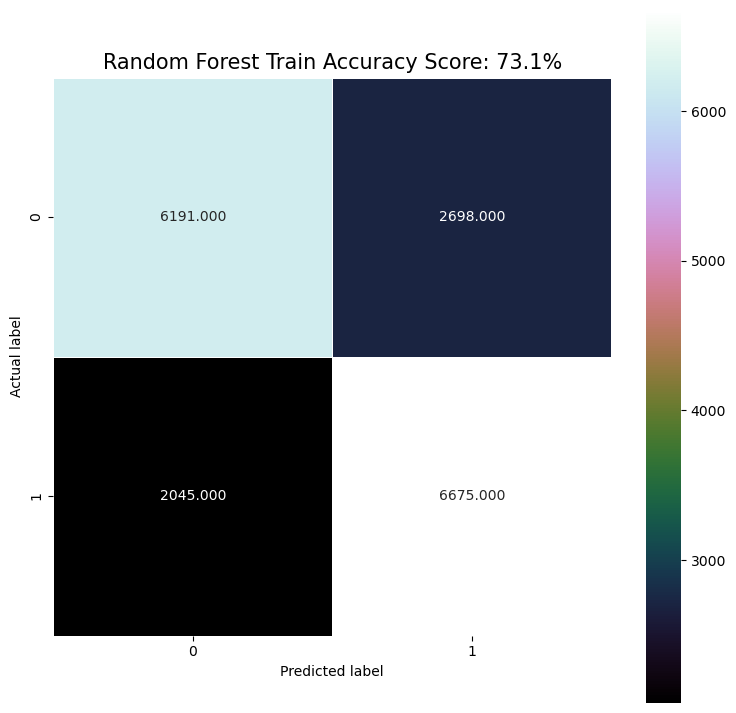

In [35]:
r_pred = rforest.predict(x_train)
r_accuracy = accuracy_score(y_train,r_pred)
r_cm = metrics.confusion_matrix(y_train, r_pred)

plt.figure(figsize=(9,9))
sns.heatmap(r_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Random Forest Train Accuracy Score: {0:.1f}%'.format(r_accuracy*100)
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(r_cm, r_accuracy, "Random Forest Train")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

In [36]:
y_test_pred = rforest.predict(x_test)
print("Test Data")
print("Accuracy  :\t", rforest.score(x_test, y_test))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

Test Data
Accuracy  :	 0.7260958437429026
TPR Test :	 0.7586538461538461
TNR Test :	 0.6969436074042187

FPR Test :	 0.3030563925957813
FNR Test :	 0.24134615384615385


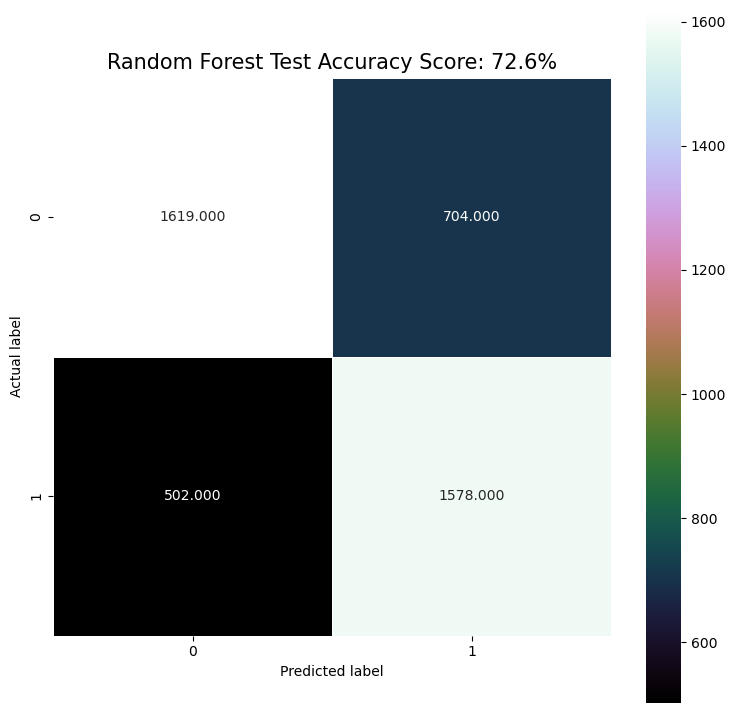

In [37]:
r_pred = rforest.predict(x_test)
r_accuracy = accuracy_score(y_test,r_pred)
r_cm = metrics.confusion_matrix(y_test, r_pred)

plt.figure(figsize=(9,9))
sns.heatmap(r_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Random Forest Test Accuracy Score: {0:.1f}%'.format(r_accuracy*100)
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(r_cm, r_accuracy, "Random Forest Test")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

Random Forest has a **slightly higher accuracy of 73%** than Decision Tree and a small difference in training and testing accuracy. Can this be improved by tuning the hyperparameters?

### Tuning hyperparameters using Cross-Validation

In [38]:
param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             

hpGrid = GridSearchCV(RandomForestClassifier(),   
                      param_grid,                 
                      cv = 5,                     
                      scoring = 'accuracy')       

hpGrid.fit(x_train, y_train.label_translated.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

In [39]:

print(hpGrid.best_estimator_)
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=7, n_estimators=500)
0.7397352882784416


The best accuracy we can obtain from this model is **74% with max_depth of 9 and 700 estimators**.

## Model 4 : Support Vector Machine Classifier

In [40]:
from sklearn import svm
svmclf = svm.SVC(kernel='linear', C=1, probability=True)
svmclf.fit(tfidf_train, y_train.values.ravel()) 

y_train_pred = svmclf.predict(tfidf_train)
print("Train Data")
print("Accuracy  :\t", svmclf.score(tfidf_train, y_train))

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

Train Data
Accuracy  :	 0.8334374467601795
TPR Train :	 0.8229357798165138
TNR Train :	 0.8437394532568343

FPR Train :	 0.15626054674316572
FNR Train :	 0.17706422018348625


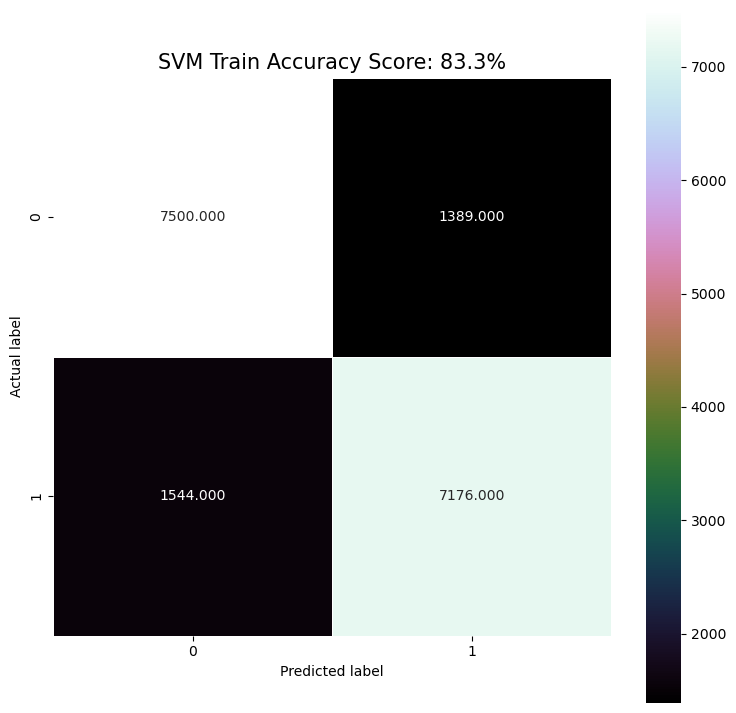

In [41]:
svm_pred = svmclf.predict(tfidf_train)
svm_accuracy = accuracy_score(y_train,svm_pred)
svm_cm = metrics.confusion_matrix(y_train, svm_pred)

plt.figure(figsize=(9,9))
sns.heatmap(svm_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'SVM Train Accuracy Score: {0:.1f}%'.format(float(svm_accuracy*100))
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(svm_cm, svm_accuracy, "SVM Train")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

In [42]:
y_test_pred = svmclf.predict(tfidf_test)
print("Test Data")
print("Accuracy  :\t", svmclf.score(tfidf_test, y_test))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

Test Data
Accuracy  :	 0.5144219850102203
TPR Test :	 0.4908653846153846
TNR Test :	 0.5355144210073182

FPR Test :	 0.4644855789926819
FNR Test :	 0.5091346153846154


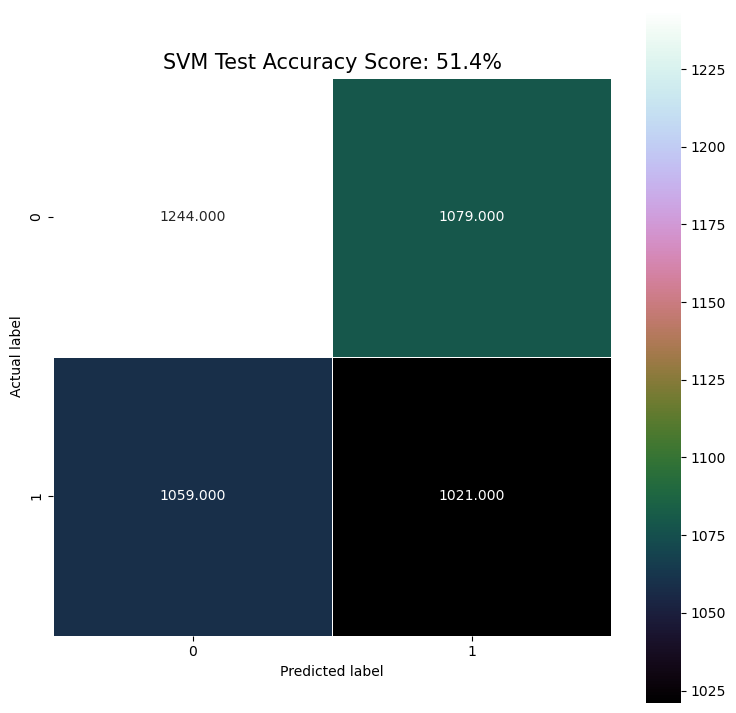

In [43]:
svm_pred = svmclf.predict(tfidf_test)
svm_accuracy = accuracy_score(y_test,svm_pred)
svm_cm = metrics.confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(9,9))
sns.heatmap(svm_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'SVM Test Accuracy Score: {0:.1f}%'.format(float(svm_accuracy*100))
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(svm_cm, svm_accuracy, "SVM Test")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

While SVM has a high accuracy of **83.2%** for the training dataset, the test dataset however **plummets to 50%**. While the high accuracy is a good sign, the **big gap of accuracy** makes this model **not** an ideal one.<br>

What about *changing type of kernel* or *tuning hyperparameters*?

### Changing kernel to non-linear kernels

In [44]:
svmclf = svm.SVC(kernel='rbf', C=1, probability=True)
svmclf.fit(tfidf_train, y_train.values.ravel()) 

y_train_pred = svmclf.predict(tfidf_train)
print("Train Data")
print("Accuracy  :\t", svmclf.score(tfidf_train, y_train))

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

Train Data
Accuracy  :	 0.9717757964677154
TPR Train :	 0.9673165137614679
TNR Train :	 0.9761502981212735

FPR Train :	 0.023849701878726516
FNR Train :	 0.03268348623853211


In [45]:
y_test_pred = svmclf.predict(tfidf_test)
print("Test Data")
print("Accuracy  :\t", svmclf.score(tfidf_test, y_test))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

Test Data
Accuracy  :	 0.5130592777651601
TPR Test :	 0.4740384615384615
TNR Test :	 0.5479982780886784

FPR Test :	 0.45200172191132154
FNR Test :	 0.5259615384615385


Changing to Radial basis function (RBF) kernel did not solve the gap issue.

In [46]:
svmclf = svm.SVC(kernel='poly', C=1, probability=True)
svmclf.fit(tfidf_train, y_train.values.ravel()) 

y_train_pred = svmclf.predict(tfidf_train)
print("Train Data")
print("Accuracy  :\t", svmclf.score(tfidf_train, y_train))

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

Train Data
Accuracy  :	 0.9821682094383554
TPR Train :	 0.9736238532110092
TNR Train :	 0.9905501181235234

FPR Train :	 0.009449881876476544
FNR Train :	 0.026376146788990827


In [47]:
y_test_pred = svmclf.predict(tfidf_test)
print("Test Data")
print("Accuracy  :\t", svmclf.score(tfidf_test, y_test))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

Test Data
Accuracy  :	 0.5087440381558028
TPR Test :	 0.3697115384615385
TNR Test :	 0.6332328885062419

FPR Test :	 0.36676711149375807
FNR Test :	 0.6302884615384615


Changing to Polynomial kernel did not solve the gap issue.

### Tuning the hyperparameters (gamma, coef0)

In [59]:
svmclf = svm.SVC(kernel='sigmoid', gamma=0.1, coef0=0.1, probability=True)
svmclf.fit(tfidf_train, y_train.values.ravel()) 

y_train_pred = svmclf.predict(tfidf_train)
print("Train Data")
print("Accuracy  :\t", svmclf.score(tfidf_train, y_train))

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

Train Data
Accuracy  :	 0.5104775966835141
TPR Train :	 0.013417431192660551
TNR Train :	 0.9980875239059511

FPR Train :	 0.0019124760940488245
FNR Train :	 0.9865825688073394


In [60]:
y_test_pred = svmclf.predict(tfidf_test)
print("Test Data")
print("Accuracy  :\t", svmclf.score(tfidf_test, y_test))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
print("FNR Test :\t", (fnTest/(tpTest + fnTest)))

Test Data
Accuracy  :	 0.5262321144674086
TPR Test :	 0.00625
TNR Test :	 0.991820921222557

FPR Test :	 0.008179078777442962
FNR Test :	 0.99375


Tuning the hyperparameters of gamma, coef0, C and changing to sigmoid kernel **solved** the gap issue, but the accuracy is **too low**.

## Model 5 : Ensemble

In [61]:
from sklearn.ensemble import VotingClassifier
estimators=[('logreg',logreg), ('clf', clf), ('rforest', rforest), ('svmclf', svmclf)]
ensemble = VotingClassifier(estimators, voting='soft')

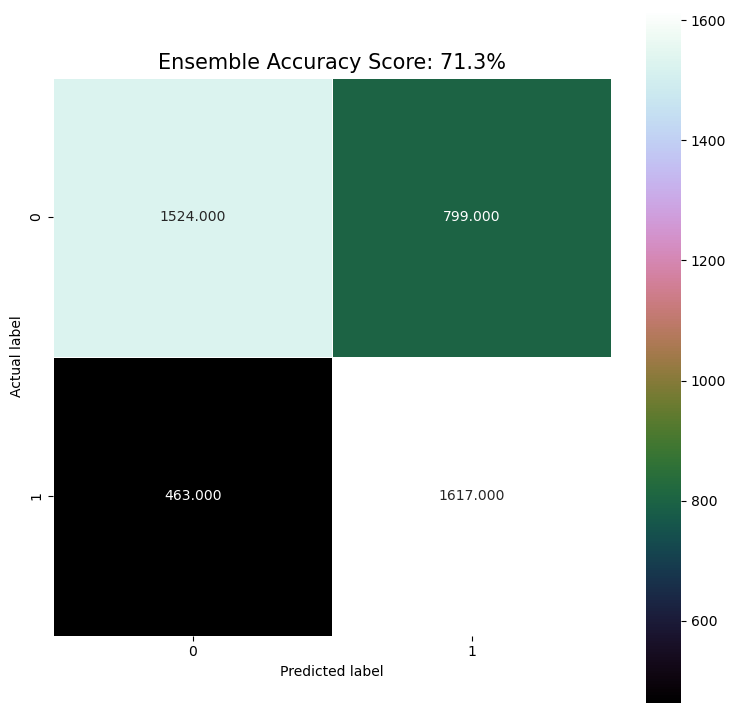

In [62]:
ensemble.fit(x_train, y_train.values.ravel())
ensemble.score(x_test, y_test)

ensemble_pred = ensemble.predict(x_test)
ensemble_accuracy = accuracy_score(y_test,ensemble_pred)
ensemble_cm = metrics.confusion_matrix(y_test, ensemble_pred)

plt.figure(figsize=(9,9))
sns.heatmap(ensemble_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Ensemble Accuracy Score: {0:.1f}%'.format(ensemble_accuracy*100)
plt.title(all_sample_title, size = 15)

accuracy_list = update_accuracy(ensemble_cm, ensemble_accuracy, "Ensemble")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

While ensemble models commonly helps to improve accuracy by combining multiple models, the model did not work for our dataset with only an accuracy of **71%**.


In [63]:
accuracy_df

,Model,Accuracy,True Pos,False Pos,True Neg,False Neg
0,Logistic-Regression Train,96.0,95.9,4.1,96.1,3.9
1,Logistic-Regression Test,93.2,92.8,7.2,93.6,6.4
2,Decision Tree Train,71.8,69.7,30.3,74.3,25.7
3,Decision Tree Test,71.1,67.5,32.5,75.2,24.8
4,Random Forest Train,73.1,71.2,28.8,75.2,24.8
5,Random Forest Test,72.6,69.1,30.9,76.3,23.7
6,SVM Train,83.3,83.8,16.2,82.9,17.1
7,SVM Test,51.4,48.6,51.4,54.0,46.0
8,Ensemble,71.3,66.9,33.1,76.7,23.3


Our task requires high accuracy on unseen data. Hence:

**Logistic Regression** performed the best and is the ideal model for our dataset. <br>
**Support Vector Machine Classifier** performed the worst as the big accuracy difference between training and testing indicates poor generalization ability.